# Integer Linear Programming (ILP) Fas Solver

Let's solve the minimum feedback arc set problem, using a linear programming relaxation.
Notation and embeddings follow the ``ranking_embedding`` one.

In [1]:
import sys
import cplex as cp
import numba
import numpy as np
sys.path.append('../..')
from ranking.fassolver.embedding import (
    fill_sym_emb, fill_emb_f8, canonical_map, 
    get_sym_emb, get_emb, get_emb_from_rank, fill_emb_from_rank
) 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

Let's consider a feedback arc set problem, with target $$\inf <\phi(y), c>,$$ and constraint 
$$\phi(y)_{ij} = \text{const}_{ij}, \qquad\text{if}\qquad \text{const}_{ij} \neq 0.$$

In [3]:
m = 10
m_emb = (m*(m-1)) // 2
ind_map = canonical_map(m)
c = np.random.randn(m_emb)

Let's first solve the unconstraint problem.

For this we will consider the Kendall's embedding, and try to approach the convex hull of $(\phi(\sigma))_{\sigma\in\mathfrak{S}}$.

To do so, we consider the transitivity constraints, for $i < j < k$
$$
    \phi_{ij} + \phi{jk} - 1 \leq \phi_{ik} \leq \phi_{ij} + \phi_{jk} + 1.
$$
We also consider the relaxation constraints $\phi_{ij} \in [-1, 1]$.

In [4]:
# Instanciate solver
solver = cp.Cplex()

# Instanciate variables with relaxation constraints
solver.variables.add(ub=[1.0] * m_emb, lb=[-1.0] * m_emb)

range(0, 45)

In [5]:
# Set transitivity constraints

# m = 10
# ind_map = canonical_map(m)

nb_const = ((m * (m + 1) * (2*m+1)) // 6 - 3 * (m * (m-1)) // 2 - m) // 2
tr_const = np.empty((nb_const, 3), dtype=np.int)

@numba.jit("(i8[:, :], i8[:, :])", nopython=True)
def _fill_tr_const(tr_const, ind_map):
    m = len(ind_map)
    ind = 0
    for k in range(m):
        for j in range(k):
            for i in range(j):
                tr_const[ind, 0] = ind_map[i, j]
                tr_const[ind, 1] = ind_map[j, k]
                tr_const[ind, 2] = ind_map[i, k]
                ind += 1
    print(ind)
print(nb_const)
    
_fill_tr_const(tr_const, ind_map)

# Formatting for cplex
cp_const = [[i, [1.0, 1.0, -1.0]] for i in tr_const.tolist()]

# x_ij + x_jk - x_ik <= 1
solver.linear_constraints.add(lin_expr=cp_const,
                              senses='L' * len(cp_const),
                              rhs=[1.0] * len(cp_const))
# x_ij + x_jk - x_ik >= -1
solver.linear_constraints.add(lin_expr=cp_const,
                              senses='G' * len(cp_const),
                              rhs=[-1.0] * len(cp_const))

120
120


range(120, 240)

In [6]:
# Set objective
solver.objective.set_linear(enumerate(c))

In [7]:
# Choose optimization method
solver.parameters.lpmethod.set(solver.parameters.lpmethod.values.primal)
print(solver.parameters.lpmethod.help())
print("Solver is set to %d." %solver.parameters.lpmethod.get())

method for linear optimization:
  0 = automatic
  1 = primal simplex
  2 = dual simplex
  3 = network simplex
  4 = barrier
  5 = sifting
  6 = concurrent optimizers
Solver is set to 1.


In [8]:
# solve the problem
solver.solve()

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                1
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.01 sec. (0.10 ticks)

Iteration log . . .
Iteration:     1    Objective     =             6.239876


In [9]:
sol_emb = np.array(solver.solution.get_values())

In [10]:
print(solver.solution.get_quality_metrics())

There are no bound infeasibilities.
There are no reduced-cost infeasibilities.
Maximum Ax-b residual              = 0
Maximum c-B'pi residual            = 5.55112e-17
Maximum |x|                        = 1
Maximum |slack|                    = 2
Maximum |pi|                       = 1.34272
Maximum |red-cost|                 = 2.797
Condition number of unscaled basis = 1.3e+01



## Adding constraints

Let's get some constraint from partial ordering

In [11]:
sigma = np.random.permutation(m)
const = get_emb(sigma, ind_map)
const *= (np.random.randn(m_emb) > .5).astype(np.float)
const[const == 0] = 0
print(const)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.
  1.  1.  0.  0. -1.  0.  1.  0.  1.]


In [12]:
# get equality constraints
ind = const != 0
index = np.arange(m_emb)[ind].tolist()
values = const[ind].tolist()

# cplex formatting
cp_const = [(index[i], values[i]) for i in range(len(index))]

solver.variables.set_lower_bounds(cp_const)
solver.variables.set_upper_bounds(cp_const)

In [13]:
solver.solve()

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                1

Iteration log . . .
Iteration:     1    Infeasibility =            14.000000
Switched to devex.
Iteration:     9    Objective     =           -20.260226


In [14]:
print(solver.solution.get_quality_metrics())

There are no bound infeasibilities.
There are no reduced-cost infeasibilities.
Maximum Ax-b residual              = 0
Maximum c-B'pi residual            = 2.22045e-16
Maximum |x|                        = 1
Maximum |slack|                    = 2
Maximum |pi|                       = 2.06343
Maximum |red-cost|                 = 3.55621
Condition number of unscaled basis = 1.9e+01



In [15]:
# Warmstart
basis = solver.solution.basis.get_basis()
solver.start.set_start(col_status=basis[0], row_status=basis[1], col_primal=[], row_primal=[], col_dual=[], row_dual=[])

# solver.solution.basis.write('sol.bas')
# solver.start.read_basis('sol.bas')

## Class

In [16]:
class IlpSolver:
    def __init__(self, ind_map, method='primal'):
        self.ind_map = ind_map
        
        # Instanciate LP
        self.solver = cp.Cplex()
        self.instanciate_variables()
        self.set_transitivity_constraints()
        
        self.choose_solver_method(method)
        self.info_for_reset = None
        
    def set_constraints(self, const):
        """
        const is of shape (m_emb,), with:
           - c[ind_map[i,j]] = 1, means that x_ij = 1
           - c[ind_map[i,j]] = -1, means that x_ij = -1
           - c[ind_map[i,j]] = 0, means that x_ij is not constrained
        """
        self.reset_constraints()
        m_emb = len(const)
        
        # get equality constraints
        ind = const != 0
        index = np.arange(m_emb)[ind].tolist()
        values = const[ind].tolist()

        # cplex formatting
        cp_const = [(index[i], values[i]) for i in range(len(index))]
        self.solver.variables.set_lower_bounds(cp_const)
        self.solver.variables.set_upper_bounds(cp_const)
        
        self.info_for_reset = index
        
    def set_objective(self, c):
        self.solver.objective.set_linear(enumerate(c))
        
    def solve(self):
        self.solver.solve()
        return np.array(self.solver.solution.get_values())
    
    def get_warmstart(self):
        basis = self.solver.solution.basis.get_basis()
        return basis
    
    def set_warmstart(self, basis):
        self.solver.start.set_start(
            col_status=basis[0], row_status=basis[1], 
            col_primal=[], row_primal=[], col_dual=[], row_dual=[])
    
    def export(self, file_name):
        self.solver.write(file_name)
        
    def import_pb(self, file_name):
        self.solver.read(file_name)
        
    def shut_up(self):
        self.solver.set_results_stream(None)
        self.solver.set_warning_stream(None)
        self.solver.set_error_stream(None)
        self.solver.set_log_stream(None) 
        
    def delete(self):
        self.solver.end()
    
    def choose_solver_method(self, solver_method):
        """
        solver method should be:
            - 'auto' for automatic
            - 'primal' = primal simplex (default)
            - 'dual' = dual simplex
            - 'network' for network simplex
            - 'barrier' for barrier
            - 'sifting' for sifting
            - 'concurrent' for concurrent optimizers
        """
        i = getattr(self.solver.parameters.lpmethod.values, solver_method)
        self.solver.parameters.lpmethod.set(i)
        
        # For gradient, the devex pricing is adapated to the type of problem we are solving
        dgradient = 'full' # 'full', 'devex',...
        i = getattr(self.solver.parameters.simplex.dgradient.values, dgradient)
        self.solver.parameters.simplex.dgradient.set(i)

        pgradient = 'steep' # 'partial', 'devex', 'steep',...
        i = getattr(self.solver.parameters.simplex.pgradient.values, pgradient)
        self.solver.parameters.simplex.pgradient.set(i)
    
    def reset_constraints(self):
        index = self.info_for_reset
        if index is None:
            return
        
        cp_const = [(index[i], -1) for i in range(len(index))]
        self.solver.variables.set_lower_bounds(cp_const)
        
        cp_const = [(index[i], 1) for i in range(len(index))]
        self.solver.variables.set_upper_bounds(cp_const)

    def instanciate_variables(self):
        m = len(self.ind_map)
        m_emb = (m*(m-1)) // 2
        self.solver.variables.add(ub=[1.0] * m_emb, lb=[-1.0] * m_emb)
        
    @staticmethod    
    @numba.jit("(i8[:, :], i8[:, :])", nopython=True)
    def _fill_tr_const(tr_const, ind_map):
        m = len(ind_map)
        ind = 0
        for k in range(m):
            for j in range(k):
                for i in range(j):
                    tr_const[ind, 0] = ind_map[i, j]
                    tr_const[ind, 1] = ind_map[j, k]
                    tr_const[ind, 2] = ind_map[i, k]
                    ind += 1

    def set_transitivity_constraints(self):
        m = len(self.ind_map)
        nb_const = ((m * (m + 1) * (2*m+1)) // 6 - 3 * (m * (m-1)) // 2 - m) // 2
        tr_const = np.empty((nb_const, 3), dtype=np.int)

        self._fill_tr_const(tr_const, self.ind_map)

        # Formatting for cplex
        cp_const = [[i, [1.0, 1.0, -1.0]] for i in tr_const.tolist()]

        # x_ij + x_jk - x_ik <= 1
        self.solver.linear_constraints.add(lin_expr=cp_const,
                                           senses='L' * len(cp_const),
                                           rhs=[1.0] * len(cp_const))
        # x_ij + x_jk - x_ik >= -1
        self.solver.linear_constraints.add(lin_expr=cp_const,
                                           senses='G' * len(cp_const),
                                           rhs=[-1.0] * len(cp_const))

In [17]:
ilp_solver = IlpSolver(ind_map)

In [18]:
ilp_solver.set_objective(c)
sol_emb = ilp_solver.solve()

CPXPARAM_Simplex_DGradient                       1
CPXPARAM_Simplex_PGradient                       2
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                1
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.01 sec. (0.10 ticks)

Iteration log . . .
Iteration:     1    Objective     =             9.767981


In [19]:
ilp_solver.set_constraints(const)
sol_emb = ilp_solver.solve()

CPXPARAM_Simplex_DGradient                       1
CPXPARAM_Simplex_PGradient                       2
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                1
Reinitializing primal norms . . .
Initializing primal norms . . .

Iteration log . . .
Iteration:     1    Infeasibility =            18.000000
Iteration:    10    Objective     =           -20.260226


## Testing result quality
We can show that when the solution of the ilp problem is in $\{-1, 1\}^{m_e}$ it is the solution of the original minimum feedback arcset problem. Let's try to see in pratice how often this arise for different $m$.

In [29]:
ms = [3, 5, 7, 10, 15, 20, 30]
nb_try = 1000
# ms = [4, 5, 6, 7, 8, 9, 10]
# nb_try = 10000
# ms = [8]
# nb_try = 10000
res = np.empty((len(ms), nb_try))

for i, m in enumerate(ms):
    ind_map = canonical_map(m)
    solver = IlpSolver(ind_map)
    solver.shut_up()
    m_emb = (m*(m-1))//2
    for j in range(nb_try):
        c = np.random.randn(m_emb)
        solver.set_objective(c)
        sol = solver.solve()
        res[i, j] = (1-np.abs(sol)).max() > 1e-5
        
#         if res[i,j]:
#             break
        if not j % 1000:
            print(j, end=',')
    print(m)

0,3
0,5
0,7
0,10
0,15
0,20
0,30


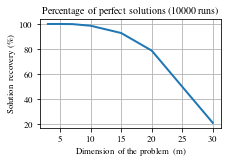

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

good = res < 1e-5
mu = good.mean(axis=1)
fig, ax = plt.subplots(figsize=(3.25, 2))
ax.plot(ms, 100*mu, linewidth=2)
# ax.set_ylim(0, 110)
ax.set_title('Percentage of perfect solutions (10000 runs)', size=10)
ax.set_ylabel('Solution recovery (\%)', size=9)
ax.set_xlabel('Dimension of the problem (m)', size=9)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
fig.savefig('ilp_sol.pdf')

## Study unimodularity

In [22]:
@numba.jit("(i8[:, :], i8[:, :])", nopython=True)
def _fill_tr_const(tr_const, ind_map):
    m = len(ind_map)
    ind = 0
    for k in range(m):
        for j in range(k):
            for i in range(j):
                tr_const[ind, ind_map[i, j]] = 1
                tr_const[ind, ind_map[j, k]] = 1 
                tr_const[ind, ind_map[i, k]] = -1 
                ind += 1

def get_transitivity_constraints(m):
    ind_map = canonical_map(m)
    nb_const = ((m * (m + 1) * (2*m+1)) // 6 - 3 * (m * (m-1)) // 2 - m) // 2
    m_emb = (m*(m-1)) // 2
    tr_const = np.zeros((nb_const, m_emb), dtype=np.int)

    _fill_tr_const(tr_const, ind_map)
    return tr_const

In [23]:
M = get_transitivity_constraints(5)

In [24]:
for i in range(100000):
#     ind_ = np.random.randn(M.shape[0]) > 0
#     ind = np.random.choice(M.shape[1], ind_.sum(), replace=False)
    
    ind = np.random.randn(M.shape[1]) > 0
    ind_ = np.random.choice(M.shape[0], ind.sum(), replace=False)
    
#     dim = 6
#     ind = np.random.choice(M.shape[1], dim, replace=False)
#     ind_ = np.random.choice(M.shape[0], dim, replace=False)
    tmp = np.linalg.det(M[ind_][:,ind])
    if tmp not in [-1, 0, 1]:
        print(tmp, end=',')
#         print(ind.sum())
        break

2.0,